<a href="https://colab.research.google.com/github/finerbrighterlighter/myanmar_covid19/blob/master/exponential_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [0]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Data

Since the Government fails to provide a complete and open dataset for disease status in the country, several young doctors in Myanmar volunteered on their own to monitor announcements. Current data applied is collected by Dr. Nyein Chan Ko Ko.

In [0]:
data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/announced_cases.csv"
columns = ["Date","Announced"]

In [49]:
confirmed_df = pd.read_csv(data,names = columns) 
confirmed_df["Date"] = pd.to_datetime(confirmed_df["Date"])
confirmed_df["Case"] = confirmed_df["Announced"].cumsum()
confirmed_df["ndays"] = np.arange(len(confirmed_df))

# Natural Log of Real Cases
confirmed_df["logCase"] = np.log(confirmed_df.Case).astype(float)

print(confirmed_df)

         Date  Announced  Case  ndays   logCase
0  2020-03-21          1     1      0  0.000000
1  2020-03-22          0     1      1  0.000000
2  2020-03-23          2     3      2  1.098612
3  2020-03-24          0     3      3  1.098612
4  2020-03-25          2     5      4  1.609438
5  2020-03-26          3     8      5  2.079442
6  2020-03-27          0     8      6  2.079442
7  2020-03-28          0     8      7  2.079442
8  2020-03-29          2    10      8  2.302585
9  2020-03-30          4    14      9  2.639057
10 2020-03-31          1    15     10  2.708050


Natural log makes it better in terms of visualization and long term comparison, make the data look more linear. That is why I will be plotting both real and natural log line graphs.

# Model of choice

True exponential does not exist, but exponential growth is assumed until the inflection point has arrived. Linear Regression is applied.

## Logistic Regression
### Ordinary Least Squared Regression

In [50]:
X = confirmed_df.ndays
X = sm.add_constant(X)
y = confirmed_df.logCase
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logCase   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     87.00
Date:                Tue, 31 Mar 2020   Prob (F-statistic):           6.37e-06
Time:                        15:07:14   Log-Likelihood:                -1.5538
No. Observations:                  11   AIC:                             7.108
Df Residuals:                       9   BIC:                             7.903
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2386      0.174      1.373      0.203      -0.155       0.632
ndays          0.2740      0.029      9.328      0.000       0.208       0.340
==============================================================================
Omnibus:                        0.096   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.953   Jarque-Bera (JB):                0.320
Skew:                          -0.032   Prob(JB):                        0.852
Kurtosis:                       2.167   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exponential Formaula<br> y = ab<sup>x</sup> <br>
a = Initial Value<br>
b = Rate of Change<br>
x = The feature ( Here it is time )<br>

b = (1+r) = Growth Rate <- Before Inflection <br>
b = (1-r) = Decay Rate <- After Inflection <br>

In the summary, "constant stands" for initial "a".<br>
"ndays" is the coefficient of "time", which means the value increasing y as x is increased by 1. In our case, the number of cases to increase as the next day comes.

In [0]:
def linear_predictions(t):
    return np.exp(result.params["const"]) * np.exp(result.params["ndays"]) ** t

As we fitted our model with natural log values, we should change them back to real numbers to predict.

# Next Week Prediction

In [52]:
ndays = len(confirmed_df)+3
nextweek_df = pd.DataFrame(columns=["ndays","Date"])
nextweek_df["ndays"] = np.arange(ndays)
nextweek_df.loc[0,"Date"]=confirmed_df.loc[0,"Date"]
for i in range(1,len(nextweek_df)):
    nextweek_df.loc[i,"Date"] = nextweek_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
nextweek_df["Predictions"] = nextweek_df.ndays.apply(linear_predictions)

# Natural Log of Predicted Cases
nextweek_df["logPredictions"] = np.log(nextweek_df.Predictions).astype(float)

print(nextweek_df)

    ndays                 Date  Predictions  logPredictions
0       0  2020-03-21 00:00:00     1.269476        0.238604
1       1  2020-03-22 00:00:00     1.669635        0.512605
2       2  2020-03-23 00:00:00     2.195930        0.786606
3       3  2020-03-24 00:00:00     2.888121        1.060606
4       4  2020-03-25 00:00:00     3.798502        1.334607
5       5  2020-03-26 00:00:00     4.995848        1.608607
6       6  2020-03-27 00:00:00     6.570617        1.882608
7       7  2020-03-28 00:00:00     8.641778        2.156608
8       8  2020-03-29 00:00:00    11.365801        2.430609
9       9  2020-03-30 00:00:00    14.948478        2.704609
10     10  2020-03-31 00:00:00    19.660470        2.978610
11     11  2020-04-01 00:00:00    25.857755        3.252611
12     12  2020-04-02 00:00:00    34.008521        3.526611
13     13  2020-04-03 00:00:00    44.728536        3.800612


Although I stated next week, here I added only "3". Since our data and history is very short right now, it is not sufficient to predict far without sacraficing. This currently here is a proof of concept. We shall increase the data and after that, we should pursure further analysis.

# Real Number Plot

In [0]:
a = str(confirmed_df["Date"][confirmed_df.index[-1]])+"_real.svg"
b = str(confirmed_df["Date"][confirmed_df.index[-1]])+"_log.svg"

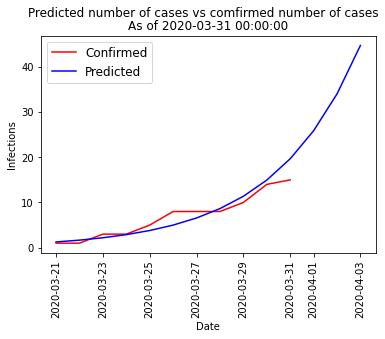

In [54]:
confirmed_x = pd.date_range(start=confirmed_df["Date"][confirmed_df.index[0]], end=confirmed_df["Date"][confirmed_df.index[-1]])
confirmed_y = confirmed_df["Case"].tolist()
confirmed_plot = pd.Series(data=confirmed_y, index=confirmed_x)

nextweek_x = pd.date_range(start=nextweek_df["Date"][nextweek_df.index[0]], end=nextweek_df["Date"][nextweek_df.index[-1]])
nextweek_y = nextweek_df["Predictions"].tolist()
nextweek_plot = pd.Series(data=nextweek_y, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_plot, label="Confirmed", color="red")
ax.plot(nextweek_plot, label="Predicted", color ="blue")
legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs comfirmed number of cases")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.savefig(a)
plt.show()
files.download(a)

# Natural Log Plot

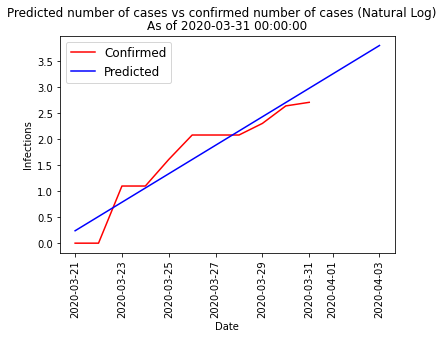

In [55]:
confirmed_logy = confirmed_df["logCase"].tolist()
confirmed_logplot = pd.Series(data=confirmed_logy, index=confirmed_x)

nextweek_logy = nextweek_df["logPredictions"].tolist()
nextweek_logplot = pd.Series(data=nextweek_logy, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_logplot, label="Confirmed", color="red")
ax.plot(nextweek_logplot, label="Predicted", color ="blue")
legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs confirmed number of cases (Natural Log)")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.savefig(b)
plt.show()
files.download(b)

In [0]:
reset